In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver


from IPython.display import Image, display
import gradio as gr


from langchain_openai import ChatOpenAI
from langchain.tools import tool

import sqlite3
import requests
import os


from  trd_agent import ChatOllama, ChatDeepSeek

from dotenv import load_dotenv
load_dotenv(override=True)


memory_ram = MemorySaver()
db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory_sql = SqliteSaver(conn)

/home/anh/workspace/course-udemy-agentic-enginer/.venv./lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check langsmithM
> See lab5c for how to register & use langsmith for logging

### create some tool in langgraph

In [2]:


pushover_token=os.getenv("PUSHOVER_API_KEY")
pushover_user=os.getenv("PUSHOVER_USER_KEY")
pushover_url="https://api.pushover.net/l/messages.json"

from langchain_community.utilities import GoogleSerperAPIWrapper #what is this?
serper = GoogleSerperAPIWrapper()
#serper.run("What is the capital of France") #example running

@tool("search")
def tool_search(query: str) -> str:
    """Useful when more information from online searches is needed."""
    return serper.run(query)

@tool("push")
def tool_push(msg: str):
    """Useful when you want to push a notification"""
    requests.post(pushover_url, data={"token": pushover_token, "user": pushover_user, "message": msg})
    return 

### langchain style tool invoke

In [3]:
tool_search.invoke("What is the capitol of france?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris, the capital city of France, is often referred to as the “City of Light” (La Vi

In [4]:
tool_push.invoke("Pretend to push a message to somewhere")

## Make our own tool

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]



tools = [tool_search, tool_push]
llm_gpt4omini = ChatOpenAI(model="gpt-4o-mini")

llm_deepseek = ChatOpenAI(
    model="deepseek-chat",                # DeepSeek chat model name
    base_url="https://api.deepseek.com/v1",
    api_key=os.environ["DEEPSEEK_API_KEY"],
    temperature=0.5,
)

llm_ollama = ChatOpenAI(
    model="qwen3-30b-instruct:latest",               # whatever model name you use in `ollama run`
    base_url="http://localhost:11434/v1",
    api_key="ollama-not-used",        # Ollama ignores it but ChatOpenAI requires *something*
    temperature=0.5,
)




In [7]:

llm = llm_deepseek
llm_with_tools = llm.bind_tools(tools)
#llm_with_tools.invoke("Hey, send me a message to my phone, saying we need to catch a bus")

llm = llm_gpt4omini
llm_with_tools = llm.bind_tools(tools)
#llm_with_tools.invoke("Hey, send me a message to my phone, saying we need to catch a bus")

llm = llm_ollama
llm_with_tools = llm.bind_tools(tools)
#llm_with_tools.invoke("Hey, send me a message to my phone, saying we need to catch a bus")

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 85, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_11f3029f6b', 'id': 'chatcmpl-CkuPSbPpn190NTdLr5SE6nSWrzWdJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b03d6-b940-7ed0-a763-5c06b7f1b570-0', tool_calls=[{'name': 'push', 'args': {'msg': 'We need to catch a bus.'}, 'id': 'call_pfwZ5buH9rbCLUlQAyv1AdBO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 85, 'output_tokens': 19, 'total_tokens': 104, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 278, 'total_tokens': 302, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'qwen3-30b-instruct:latest', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-554', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b03d6-bdb7-72c0-9708-1889ccd61a2c-0', tool_calls=[{'name': 'push', 'args': {'msg': 'We need to catch a bus'}, 'id': 'call_hl8u72ot', 'type': 'tool_call'}], usage_metadata={'input_tokens': 278, 'output_tokens': 24, 'total_tokens': 302, 'input_token_details': {}, 'output_token_details': {}})

In [10]:
### Declare graph for chat bot

In [8]:
def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}



graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


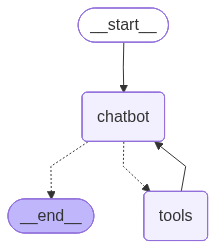

In [9]:
graph = graph_builder.compile(checkpointer=memory_sql)
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
config = {"configurable": {"thread_id": "1"}}

def invoke_graph(user_input: str, history):
    # note: we do not use history here, to test memory save capability
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(fn=invoke_graph).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [ ]:
graph.get_state(config)